## Notebook for reading in results of cross-validaton of ML models fit on the dataset for Open-Source Reservoir (CMG simulations) 

Code in this notebook looks at the MAPE error estimates for the models fit in the process of cross-validation and allows identifying optimal model/training parameters.

-------

*Written by: Dmitry Duplyakin (dmitry.duplyakin@nrel.gov) in collaboration with the National Renewable Energy Laboratories.*

*Full team: Dmitry Duplyakin, Koenraad F. Beckers, Drew L. Siler, Michael J. Martin, Henry E. Johnston*

### Necessary Configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import uuid
from datetime import datetime
import glob
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold

loglevel = 'WARNING'
logging.basicConfig(level=os.environ.get("LOGLEVEL", loglevel))

# Import config file that is specific to CMG dataset
sys.path.append('../data/OpenSourceReservoir-CMG')
sys.path.append('../')

import config_cmg as config

#sys.path.append('..')
from reservoir.reservoir import Reservoir, ReservoirPredictionEnsemble

from polynomial import get_polynomial_func

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('ggplot')

In [2]:
batch_id = "OSR-CV"
res_dir = "../results/error_summaries/"
dest_file = os.path.join(res_dir, "batch-%s.csv" % (str(batch_id)))
loaded_results_df = pd.read_csv(dest_file)

display(loaded_results_df)

,timestamp,train_idx,quantity,degree,nn,n_epochs,loss,k,mape_list,mae_list,mape_avg,mae_avg
0,2021-11-20 20:17:09.186509,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[12, 6]",250,mae,10,"[2.9472277975868364, 1.2782309663927875, 0.729...","[544.9526532607288, 251.63283360442176, 169.60...",0.825090,169.698494
1,2021-11-20 20:18:04.448774,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[12, 12]",250,mae,10,"[4.025413011976615, 0.9117854749115544, 0.2714...","[742.8219365677421, 179.99538816831418, 63.029...",1.002146,209.283774
2,2021-11-20 20:19:00.212845,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[16, 8]",250,mae,10,"[1.6226499053366743, 0.19672533770632084, 0.45...","[300.2119577765664, 38.9248718662849, 107.1910...",0.861885,179.904075
3,2021-11-20 20:19:56.498958,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[16, 16]",250,mae,10,"[3.07655447568534, 2.4734963061311612, 0.89370...","[565.262644241023, 486.5495099534298, 207.8991...",0.963397,197.735710
4,2021-11-20 20:20:53.204994,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[24, 12]",250,mae,10,"[1.9225395815914408, 1.062757760639499, 2.5390...","[355.6594014893129, 209.5790974638095, 596.665...",1.032800,214.824486
...,...,...,...,...,...,...,...,...,...,...,...,...
859,2021-11-22 10:31:16.948318,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pt6,6,"[16, 16]",1000,mae,10,"[0.48908020127712326, 3.4120722664008625, 0.80...","[0.879524876516643, 5.87051704763204, 1.274687...",3.358269,5.313810
860,2021-11-22 10:35:00.157749,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pt6,6,"[24, 12]",1000,mae,10,"[1.327495971869418, 1.1446399256315818, 3.2709...","[2.3938139558196987, 1.972434676257694, 5.1608...",2.652577,4.149031
861,2021-11-22 10:38:48.760874,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pt6,6,"[24, 24]",1000,mae,10,"[1.6530775244611398, 2.6608913165810084, 2.773...","[2.9794983521802623, 4.563748573868892, 4.3704...",3.305686,5.066085
862,2021-11-22 10:42:41.266494,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pt6,6,"[32, 16]",1000,mae,10,"[1.4354629368461296, 1.3340178619654213, 1.162...","[2.58722602797342, 2.2920010978185124, 1.83405...",3.257627,5.107888


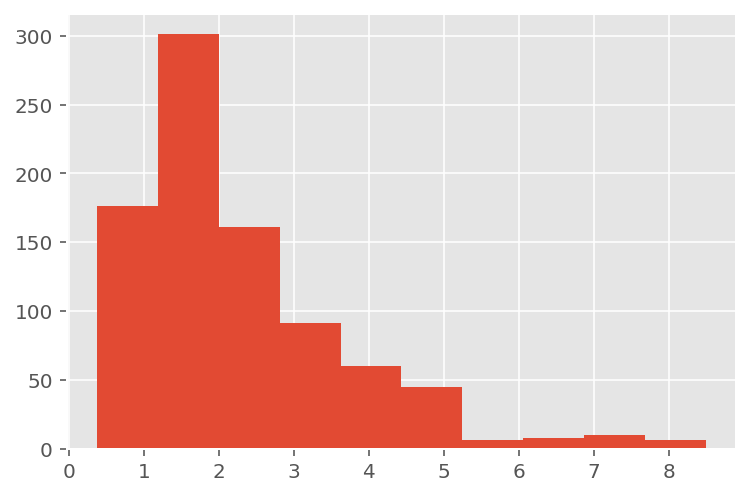

In [3]:
loaded_results_df.mape_avg.hist();

In [4]:
loaded_results_df.degree.value_counts()

6    288
5    288
4    288
Name: degree, dtype: int64

In [5]:
loaded_results_df.n_epochs.value_counts()

1000    288
500     288
250     288
Name: n_epochs, dtype: int64

In [6]:
loaded_results_df.quantity.value_counts()

pp3    72
pt2    72
pt6    72
pt5    72
pt1    72
pt4    72
pt3    72
pp5    72
pp2    72
pp1    72
pp6    72
pp4    72
Name: quantity, dtype: int64

In [7]:
loaded_results_df[loaded_results_df["quantity"] == "pp1"].sort_values("mape_avg")

,timestamp,train_idx,quantity,degree,nn,n_epochs,loss,k,mape_list,mae_list,mape_avg,mae_avg
194,2021-11-21 00:50:29.462366,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[16, 8]",1000,mae,10,"[1.09241063591265, 0.09345471593712029, 0.1750...","[201.57129347071216, 18.541420075534862, 40.19...",0.475926,99.567561
192,2021-11-21 00:43:39.922754,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[12, 6]",1000,mae,10,"[0.7658750937458348, 0.74196334329551, 0.25434...","[141.1013280990762, 145.74197722110713, 58.875...",0.533494,110.180301
193,2021-11-21 00:47:03.408646,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[12, 12]",1000,mae,10,"[0.6227512286232473, 0.3680606784770772, 0.573...","[114.84302330308647, 72.61761538788953, 134.15...",0.568418,119.412250
198,2021-11-21 01:04:40.175218,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[32, 16]",1000,mae,10,"[0.9295016695529179, 0.2652620046417411, 0.267...","[171.12830862727472, 52.28429247910906, 61.852...",0.569957,118.569005
199,2021-11-21 01:08:16.936828,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[32, 32]",1000,mae,10,"[0.706630497867341, 0.26471398625260323, 0.405...","[130.24786521469585, 52.28316478082098, 95.123...",0.596290,125.172741
...,...,...,...,...,...,...,...,...,...,...,...,...
581,2021-11-21 16:23:54.740909,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,6,"[24, 24]",250,mae,10,"[1.2472796363404397, 4.433133128315866, 1.1239...","[229.32712993955658, 869.7576213437536, 264.20...",2.669995,558.973498
579,2021-11-21 16:21:58.903844,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,6,"[16, 16]",250,mae,10,"[3.8726900665980994, 1.612980701836543, 0.7871...","[710.5882479626691, 317.91935519750825, 184.03...",2.882768,598.956200
577,2021-11-21 16:20:09.396546,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,6,"[12, 12]",250,mae,10,"[2.6511273407792495, 2.9054616149511454, 3.330...","[490.4199428198068, 569.7924272887844, 783.933...",2.887951,598.328420
580,2021-11-21 16:22:54.625327,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,6,"[24, 12]",250,mae,10,"[8.461846213448766, 1.6703029083737675, 2.3292...","[1557.9838808828185, 329.43148829043673, 552.9...",2.893527,601.899532


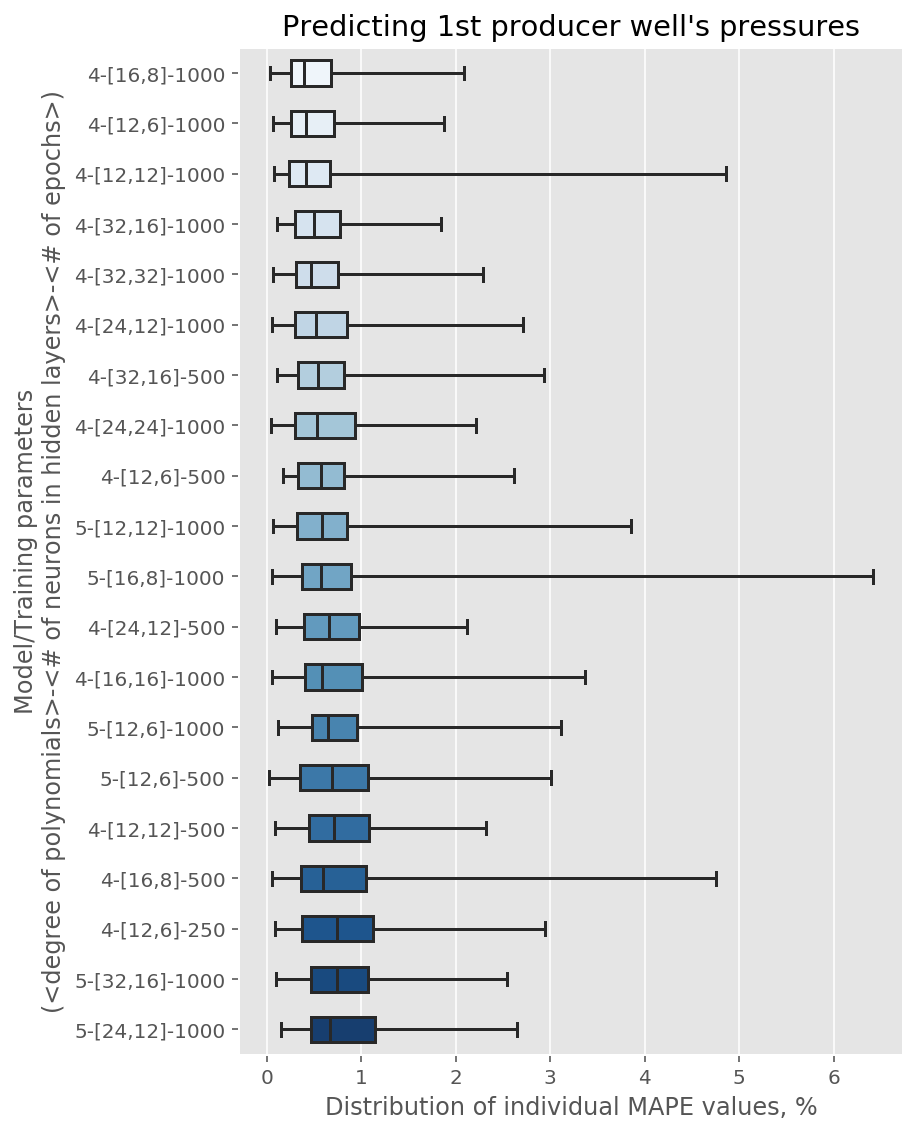

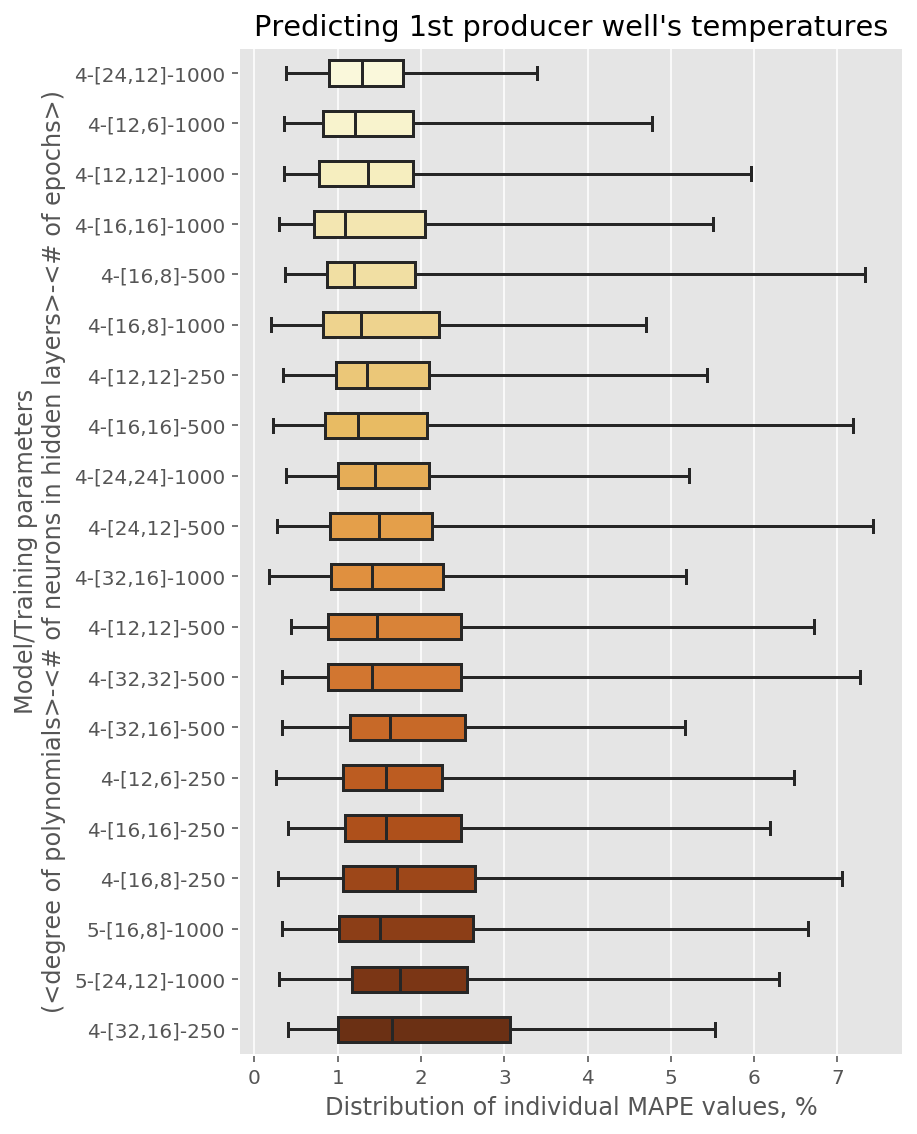

In [8]:
for selected_q in loaded_results_df.quantity.unique():
    if selected_q in ["pp1", "pt1"]:
        one_q_results = loaded_results_df[loaded_results_df["quantity"] == selected_q].sort_values("mape_avg")
        to_plot = pd.DataFrame()
        for idx, row in one_q_results[:20].iterrows():
            #row_label = str(row["quantity"]) + "-" + str(row["degree"]) + "-" + str(row["nn"]).replace(" ", "") + "-" + str(row["n_epochs"])
            row_label = str(row["degree"]) + "-" + str(row["nn"]).replace(" ", "") + "-" + str(row["n_epochs"])
            #print(row_label)
            to_plot = pd.concat([to_plot, pd.DataFrame({"params": row_label, "mape": [float(s) for s in row.mape_list.replace("[", "").replace("]", "").split(",")]})])
        #display(to_plot)

        if selected_q.startswith("pp"):
            palette = "Blues"
        elif selected_q.startswith("pt"):
            palette = "YlOrBr"
        
        fig, ax = plt.subplots(figsize=(6.5, 8))
        sns.boxplot(x="mape", y="params", data=to_plot,
                    whis=[0, 100], width=.5, palette=palette, 
                    ax=ax)
        ax.set_xlabel("Distribution of individual MAPE values, %");
        ax.set_ylabel("Model/Training parameters\n(<degree of polynomials>-<# of neurons in hidden layers>-<# of epochs>)");
        ax.set_title("Error estimates for predictions: %s" % selected_q)
        #ax.set_title("Error estimates for predictions: %s" % selected_q)
        
        if selected_q == "pp1":
            ax.set_title("Predicting 1st producer well's pressures")
        elif selected_q == "pt1":
            ax.set_title("Predicting 1st producer well's temperatures")
        plt.tight_layout()
        plt.savefig("../figures/" + selected_q + "-cv_error_boxplot.png", dpi=300)
        plt.show();

In [9]:
nn_ranks_df = pd.DataFrame()
for selected_q in loaded_results_df.quantity.unique():
    one_q_results = loaded_results_df[(loaded_results_df["quantity"] == selected_q) & (loaded_results_df["degree"] == 4) & (loaded_results_df["n_epochs"] == 1000)].sort_values("mape_avg").copy()
    one_q_results.reset_index(inplace=True, drop=True)
    
    nn_ranks_df = pd.concat([nn_ranks_df, pd.DataFrame({"rank": one_q_results.index, "nn": one_q_results.nn})])
display(nn_ranks_df)

print("Combinations at the top of the following list are the best according to the rankings for all studied quantities:")
nn_ranks_df.groupby("nn")["rank"].apply(sum).sort_values()

,rank,nn
0,0,"[16, 8]"
1,1,"[12, 6]"
2,2,"[12, 12]"
3,3,"[32, 16]"
4,4,"[32, 32]"
...,...,...
3,3,"[16, 8]"
4,4,"[32, 32]"
5,5,"[16, 16]"
6,6,"[24, 24]"


Combinations at the top of the following list are the best according to the rankings for all studied quantities:


nn
[12, 6]     20
[16, 8]     30
[12, 12]    36
[24, 12]    39
[32, 16]    45
[32, 32]    48
[24, 24]    57
[16, 16]    61
Name: rank, dtype: int64